In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib
import os


In [2]:
import pandas as pd

df = pd.read_csv("C:/Users/nayak/AutoStock.AI/data/train.csv", parse_dates=["date"])


In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df.dropna(inplace=True)
df = df[df["sales"] >= 0]
df.sort_values(["store_nbr", "family", "date"], inplace=True)


In [10]:
# Focus on one store + one family for now
store, family = 1, 'GROCERY I'
df = df[(df['store_nbr'] == store) & (df['family'] == family)].copy()

# Feature engineering
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df = df.set_index('date').resample('D').sum().fillna(0).reset_index()

C:\Users\nayak\AppData\Local\Temp\ipykernel_6748\1435798033.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.set_index('date').resample('D').sum().fillna(0).reset_index()


In [11]:
from sklearn.preprocessing import MinMaxScaler

features = ['sales', 'onpromotion', 'day_of_week', 'month']
scalers = {col: MinMaxScaler() for col in features}
for col in features:
    df[col] = scalers[col].fit_transform(df[[col]])

# Save scalers
import joblib, os
model_dir = "../backend/ml_service/model"
os.makedirs(model_dir, exist_ok=True)
joblib.dump(scalers, f"{model_dir}/scalers_dict.save")


['../backend/ml_service/model/scalers_dict.save']

In [12]:
def create_sequences(df, window):
    X, y = [], []
    for i in range(len(df) - window):
        seq_x = df.iloc[i:i+window][features].values
        seq_y = df.iloc[i+window]['sales']
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(df, window_size)


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, len(features))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])


Epoch 1/50
47/47 [==============================] - 9s 62ms/step - loss: 0.0117 - val_loss: 0.0074
Epoch 2/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0071 - val_loss: 0.0075
Epoch 3/50
47/47 [==============================] - 2s 35ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 4/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 5/50
47/47 [==============================] - 2s 33ms/step - loss: 0.0065 - val_loss: 0.0074
Epoch 6/50
47/47 [==============================] - 2s 35ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 7/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 8/50
47/47 [==============================] - 2s 34ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/50
47/47 [==============================] - 2s 36ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 10/50
47/47 [==============================] - 2s 37ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 11/

In [14]:
model.save(f"{model_dir}/lstm_refined_model.h5")


52/52 [==============================] - 4s 11ms/step


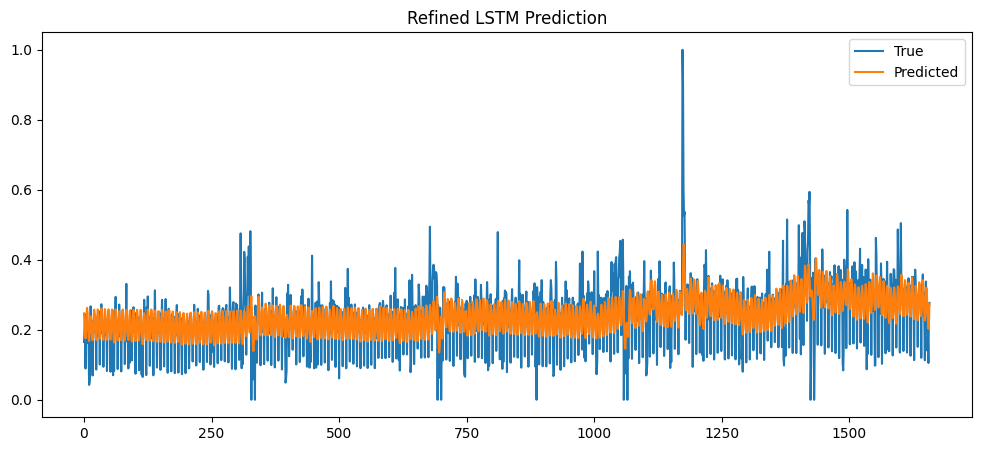

In [15]:
pred = model.predict(X)
plt.figure(figsize=(12,5))
plt.plot(y, label="True")
plt.plot(pred, label="Predicted")
plt.title("Refined LSTM Prediction")
plt.legend()
plt.show()
